In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import folium
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.plotly as plotl
import plotly.graph_objs as go
import plotly.tools as tls
import urllib2
import urllib
import time
import json
import nltk
import string
import geocoder
import itertools
import re
import os, csv
import collections
import preprocessor as p
from pylab import rcParams
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from plotly.tools import FigureFactory as FF
from textblob import TextBlob
from pandas.io.json import json_normalize
from functools import partial
from multiprocessing import Pool
from pattern.text.en import singularize
from pattern.en import parse
from pattern.en import tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from unicodedata import normalize
import unicodedata as ud
from nltk import bigrams 
from geopy.geocoders import Nominatim
plt.style.use('ggplot')  
tls.set_credentials_file(username='nweat', api_key='BgNMfzTIbo5F2wPiSCCF')
from unidecode import unidecode
import sys
default_stdout = sys.stdout
default_stderr = sys.stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout = default_stdout
sys.stderr = default_stderr
pd.set_option('max_colwidth', 800)
###################################################################
## USEFUL FOR ANALYSIS, VISUALIZATIONS
#http://kyrandale.com/static/talks/reveal.js/index_pydata2015.html#/3
#http://adilmoujahid.com/posts/2015/01/interactive-data-visualization-d3-dc-python-mongodb/
#http://www.d3noob.org/2013/02/update-d3js-data-dynamically-button.html
#textblob
#https://www.quora.com/What-are-the-best-ways-to-do-Twitter-sentiment-analysis-in-R-with-offline-datasets
#csvDf.to_json(path_or_buf = None, orient = 'records', date_format = 'epoch', double_precision = 10, force_ascii = True, date_unit = 'ms', default_handler = None)
#http://machinelearningmastery.com/time-series-data-visualization-with-python/
#http://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm
#https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3

In [18]:
##################################################################################
# LOAD VARIABLES
###################################################################################
mood_lexicon_output = 'final_data/mood_lexicon.csv'
CSV_labeledMissingGeo_output = 'final_data/labelMIssingGeo_normalusers.csv' #output from multi_processing_file
CSV_preprocessing_output = 'final_data/labelMIssingGeo_preprocessed_normalusers.csv'
CSV_sentiment140_output = 'final_data/labelMIssingGeo_preprocessed_sentiment_normalusers.csv'
CSV_emotion_output = 'final_data/labelMIssingGeo_preprocessed_sentiment_emotion_normalusers.csv'
CSV_keywords_output = 'final_data/labelMIssingGeo_preprocessed_sentiment_emotion_keywords_normalusers.csv'
tweets = pd.read_table(CSV_labeledMissingGeo_output, sep=',') #initial data loading
NORMAL_USERS = 'final_data/users_final_normal/'
STOP = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatiser = WordNetLemmatizer()

##################################################################################
# HELPER FUNCTIONS
###################################################################################

# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller of max size chunkSize (last is smaller)
# http://stackoverflow.com/questions/17315737/split-a-large-pandas-dataframe
def splitDataFrameIntoSmaller(df, chunkSize = 10000): 
    listOfDf = list()
    numberChunks = len(df) // chunkSize + 1
    for i in range(numberChunks):
        listOfDf.append(df[i*chunkSize:(i+1)*chunkSize])
    return listOfDf

##################################################################################
# Lable emojis with their emotion *NOT PRIORITY
##################################################################################
EMOJI_LIST = pd.read_csv('emoji_table.csv', encoding='utf-8')
def unicodeEscapeEmoji(row):
    row['unicode_escape'] = row['emoji'].encode('unicode_escape')
    return row
EMOJI_LIST = EMOJI_LIST.apply(unicodeEscapeEmoji, axis = 1)
EMOJI_LIST.head(4)


##################################################################################
# MOOD LEXICON PREPARATION (DEPECHE MOOD LEXICON: AFRAID, AMUSED, ANGRY, ANNOYED, DONT CARE, HAPPY, INSPIRED, SAD)
# DESCRIPTION: 
# Extract Lemma, label NTLK POS
# REFERENCES: http://www.nltk.org/book/ch05.html
###################################################################################
mood_lexicon = pd.read_table('DepecheMood_V1.0/DepecheMood_normfreq.txt')

def extractPOS(lemmaPos):
    return lemmaPos.split('#')[1]

def extractLemma(lemmaPos):
    return lemmaPos.split('#')[0]

def labelNLTKPos(pos):
    if pos == 'n':
        return 'NN'
    elif pos == 'a':
        return 'JJ'
    elif pos == 'r':
        return 'RB'
    elif pos == 'v':
        return 'V'
       
mood_lexicon['POS'] = mood_lexicon['Lemma#PoS'].apply(extractPOS)
mood_lexicon['Lemma'] = mood_lexicon['Lemma#PoS'].apply(extractLemma)
mood_lexicon['NLTKPos'] = mood_lexicon['POS'].apply(labelNLTKPos)
mood_lexicon.to_csv(mood_lexicon_output, index = False)
#mood_lexicon['Max_Weight'] = mood_lexicon[['AFRAID','AMUSED','ANGRY','ANNOYED','DONT_CARE','HAPPY','INSPIRED','SAD']].max(axis=1)
#mood_lexicon[mood_lexicon['Lemma'].isin(['friend','sad','lonely', 'kill', 'happy','never'])]


initial_split = splitDataFrameIntoSmaller(tweets, 50000)
for i in initial_split:
    print len(i)
#tweets.username.unique()  ##repost #repost #father #son' nan '#repost #cockails #manchester

50000
50000
50000
50000
50000
11390


In [42]:

textt = 'You are appreciated. Thank you. You are hated hated upper-class running happyyyyy ✊🏽🙌🏽.'.lower()
textt = re.sub(r"([a-z])\-([a-z])", r"\1 \2", textt , 0, re.IGNORECASE)
textt = textt.translate(None, string.punctuation)
#textt = re.sub(r'(.)\1\1\1+', r'\1', textt)   
#textt = ''.join(ch for ch, _ in itertools.groupby(textt))
textt = textt.encode('utf-8').encode('unicode_escape')
wordss = textt.split()
#text = " ".join(sorted(set(wordss), key=wordss.index))
tokenizedd = nltk.word_tokenize(textt)
tokenizedd = list(set(tokenizedd))
stop_words_removedd = [w for w in tokenizedd if not w in STOP]
#stop_words_punc_removed = [l for l in stop_words_removed if l not in string.punctuation]
nouns = [lemmatiser.lemmatize(word,pos="n") for word, pos in tag(textt) if pos.startswith("N") == True]
verbs = [lemmatiser.lemmatize(word, pos="v") for word, pos in tag(textt) if pos.startswith("V") == True]
adverb = [lemmatiser.lemmatize(word, pos="r") for word, pos in tag(textt) if pos.startswith("R") == True]
adjectives = [lemmatiser.lemmatize(word,pos="a") for word, pos in tag(textt) if pos.startswith("J") == True]
print nouns
print verbs
print adverb
print adjectives

subject = textt
subject = re.sub(r"([a-z])\-([a-z])", r"\1 \2", subject , 0, re.IGNORECASE)
subject = subject.translate(None, string.punctuation)
tokenized = list(set(tokenizedd))
print subject
print tokenizedd

[u'thank', u'class', u'happyyyyy', u'\\u270a\\U0001f3fd\\U0001f64c\\U0001f3fd']
[u'be', u'appreciate', u'be', u'hat', u'hat', u'run']
[]
[u'upper']
you are appreciated thank you you are hated hated upper class running happyyyyy u270aU0001f3fdU0001f64cU0001f3fd
['upper', 'thank', 'hated', '\\u270a\\U0001f3fd\\U0001f64c\\U0001f3fd', 'class', 'running', 'are', 'happyyyyy', 'you', 'appreciated']


In [48]:
##################################################################################
# REMOVE RETWEETS FROM DATA *DIDNT IMPLEMENT THIS
##################################################################################
mask = tweets['tweetText'].str.contains('RT @')
tweets[mask]

,userid,username,tweetCreated,tweetLang,tweetText,hashtags,mentions,favorites,retweet,tweetLat,tweetLong,userLocation,countryCode
3,73755799,badkidvictoria,2017-02-14 17:56:15,en,"RT @ladygaga: Happy Valentine's Day everyone. If you have someone special, give them a kiss. If you don't, make a voodoo doll of your ex an…",NaN,@ladygaga,0,50150,53.493680,-2.186851,NaN,NaN
5,73755799,badkidvictoria,2017-02-14 17:11:48,en,RT @FeudFX: They hated each other. And we loved them for it. Watch the OFFICIAL TRAILER for FEUD: Bette and Joan. Premieres 3/5 on @FXNetwo…,NaN,@FeudFX @FXNetwo,0,1692,53.493680,-2.186851,NaN,NaN
7,73755799,badkidvictoria,2017-02-14 14:40:06,en,RT @AstrologyOnIy: the signs as 2016 albums\r\r\n\r\r\naries ♈️ • joanne (lady gaga) https://t.co/RKnHWMyBru,NaN,@AstrologyOnIy,0,289,53.493680,-2.186851,NaN,NaN
11,73755799,badkidvictoria,2017-02-13 01:53:33,en,RT @Paula_PawsUp: FUCK ME TF UP https://t.co/aRQieXffal,NaN,@Paula_PawsUp,0,26,53.493680,-2.186851,NaN,NaN
12,73755799,badkidvictoria,2017-02-13 01:04:23,en,RT @holyh00ker: Wig is off. So are my pants. https://t.co/ATxPb1rsSJ,NaN,@holyh00ker,0,40,53.493680,-2.186851,NaN,NaN
17,73755799,badkidvictoria,2017-02-10 19:35:03,en,"RT @ladygaga: Wow!💘Thank u monsters, I'm so excited+grateful to see our shows selling out so quickly! Adding more dates where we can CANT W…",NaN,@ladygaga,0,8930,53.493680,-2.186851,NaN,NaN
20,73755799,badkidvictoria,2017-02-09 15:35:01,en,RT @bestofsusan: Susan Sarandon for 'Madame Figaro' magazine - 2016 \r\r\n\r\r\n(2/2) https://t.co/SKVSe6nVDU,NaN,@bestofsusan,0,11,53.493680,-2.186851,NaN,NaN
27,73755799,badkidvictoria,2017-02-07 12:40:03,und,RT @ladygaga: 🏈🏈#SB51 #PepsiHalftime #GagaBowl https://t.co/rDWCXd673N,#sb51 #pepsihalftime #gagabowl,@ladygaga,0,36035,53.493680,-2.186851,NaN,NaN
28,73755799,badkidvictoria,2017-02-06 03:33:22,en,"RT @HillaryClinton: I'm one of 100 million #SuperBowl fans that just went #Gaga for the Lady, &amp; her message to all of us. https://t.co/8AoN…",#superbowl #gaga,@HillaryClinton,0,62398,53.493680,-2.186851,NaN,NaN
32,73755799,badkidvictoria,2017-02-06 00:50:36,en,"RT @ladygaga: This is for you, Monsters. I love you. https://t.co/1Wh56OThzm",NaN,@ladygaga,0,50229,53.493680,-2.186851,NaN,NaN


In [88]:
##################################################################################
# PREPROCESS EVERY TWEET
# DESCRIPTION:
# Remove URL, mentions, RT word, 
# REFERENCES:
# http://www.clips.ua.ac.be/pages/pattern-en#ngram
# POSSIBLE FIXES:
# Spelling errors
# Fix stemming e.g. jesu should be jesus
# Replace emojis and smileys with word emotion
# To speed up: http://stackoverflow.com/questions/26784164/pandas-multiprocessing-apply
# http://iacs-courses.seas.harvard.edu/courses/iacs_projects/sentimentanalysisforfinance.wordpress.com/data-preprocessing/index.html
# TO ADD IF HAVE TIME:
# ADDITIONS IF HAVE TIME: replace emoji with emotion name, smileys, remove retweets and duplicate tweets?? 
# remove numbers:
# https://github.com/nweat/mental-health-research/blob/master/patient_tweet_analysis/tweets-keyword-extraction.py
# https://marcobonzanini.com/2015/01/26/stemming-lemmatisation-and-pos-tagging-with-python-and-nltk/
###################################################################################
p.set_options(p.OPT.NUMBER) #p.OPT.SMILEY, p.OPT.EMOJI, 
frames = []
dfID = 0

def preprocessTweet(row):
    # must do this preprocessing step: lower text, remove mentions,numbers, puncutation, RT, URLS, # sign but leave hashtag text, stemming
    text = str(row['tweetText']).lower()
    text = re.compile(r"(?:\@|https?\://)\S+").sub('', re.compile('rt @').sub('@', text).strip())
    text = re.sub("[#]", "", text).strip()
    text = p.clean(text)
    #text = re.sub(r"(?:[a-z][a-z'\-_]+[a-z])", "", text).strip() 
    #text = re.sub(r"([a-z])\-([a-z])", r"\1 \2", text , 0, re.IGNORECASE) # remove dashes in words
    text = text.translate(None, string.punctuation)
    words = text.split()
    #text = " ".join(sorted(set(words), key=words.index))
    text = text.encode('utf-8').encode('unicode_escape')
     
    #text = unidecode(text.replace('"',''))
    tokenized = nltk.word_tokenize(text) #text.split() #word_tokenize(text)
    tokenized = list(set(tokenized)) # remove duplicates
    #tokenized = [singularize(plural) for plural in tokenized] #stemmer
    
    stop_words_removed = [w for w in tokenized if not w in STOP]
    #stop_words_punc_removed = [l for l in stop_words_removed if l not in string.punctuation]
    #tokenized_postag = nltk.pos_tag(tokenized)
    nouns = [lemmatiser.lemmatize(word,pos="n") for word, pos in tag(text) if pos.startswith("N") == True]
    verbs = [lemmatiser.lemmatize(word, pos="v") for word, pos in tag(text) if pos.startswith("V") == True]
    adverb = [lemmatiser.lemmatize(word, pos="r") for word, pos in tag(text) if pos.startswith("R") == True]
    adjectives = [lemmatiser.lemmatize(word, pos="a") for word, pos in tag(text) if pos.startswith("J") == True]
    row['stopWordsPuncRemoved'] = stop_words_removed #stop_words_punc_removed
    row['withStopWords'] = tokenized
    row['adjectives'] = adjectives
    row['verbs'] = verbs
    row['adverb'] = adverb
    row['nouns'] = nouns
    return row

for i in initial_split:
    preprocessTweets = splitDataFrameIntoSmaller(i, 3500)
    print '\nInitial frame: %d\n' % len(i)
    
    for i in preprocessTweets:
        dfID += 1
        dfName = 'df' + str(dfID)
        print dfName
        i = i.apply(preprocessTweet, axis = 1)
        frames.append(i)
    #break

preprocessedTweets = pd.concat(frames)
preprocessedTweets.to_csv(CSV_preprocessing_output, mode='a', index = False, quotechar='"', quoting = csv.QUOTE_NONNUMERIC)
preprocessedTweets.head(2) #[preprocessedTweets['username'] == 'RashadHouston']


Initial frame: 50000

df1
df2
df3
df4
df5
df6
df7
df8
df9
df10
df11
df12
df13
df14
df15

Initial frame: 50000

df16
df17
df18
df19
df20
df21
df22
df23
df24
df25
df26
df27
df28
df29
df30

Initial frame: 50000

df31
df32
df33
df34
df35
df36
df37
df38
df39
df40
df41
df42
df43
df44
df45

Initial frame: 50000

df46
df47
df48
df49
df50
df51
df52
df53
df54
df55
df56
df57
df58
df59
df60

Initial frame: 50000

df61
df62
df63
df64
df65
df66
df67
df68
df69
df70
df71
df72
df73
df74
df75

Initial frame: 11390

df76
df77
df78
df79


,userid,username,tweetCreated,tweetLang,tweetText,hashtags,mentions,favorites,retweet,tweetLat,tweetLong,userLocation,countryCode,stopWordsPuncRemoved,withStopWords,adjectives,verbs,adverb,nouns
0,591961037,Stacey_Smilelee,2017-04-18 00:16:42,en,Did somebody call a #DOCTOR ?!?\r\nJust settling the family into our seats at the theatre for the… https://t.co/HKmNMigrOn,#doctor,NaN,0,1,36.108799,-86.816987,Nashville,US,"[settling, somebody, family, doctor, call, seats, theatre, the\u2026]","[a, settling, somebody, family, just, doctor, did, into, for, call, at, seats, theatre, our, the, the\u2026]",[],"[do, call]",[just],"[somebody, doctor, family, seat, theatre, the\u2026]"
1,591961037,Stacey_Smilelee,2017-04-16 20:05:44,en,Time to #Pacques Eggs (the #Cajun tradition of #KnockingEggs 🐣) https://t.co/t8uGmR6kj9,#pacques #cajun #knockingeggs,NaN,0,0,35.764271,-83.320564,Nashville,NaN,"[pacques, cajun, knockingeggs, eggs, \U0001f423, time, tradition]","[pacques, cajun, knockingeggs, of, eggs, \U0001f423, to, time, the, tradition]",[cajun],[\U0001f423],[],"[time, pacques, egg, tradition, knockingeggs]"


In [33]:
preprocessedTweets['stopWordsPuncRemoved']

0                                                                                 [blessed, grille, \U0001f60b\U0001f337\U0001f423, brunch, easter, happyeaster]
1                                                                                             [freeform, twilightmarathon, soundsgoodtome, \U0001f44d\U0001f3fb]
2                                                                                                                             [\U0001f337\U0001f423, traditions]
3                                                       [\U0001f36c\U0001f36d\U0001f370, happybirthday, sweet16, grill, carrabbas, cake, springs, cool, italian]
4              [happybirthday, \U0001f495\U0001f49c\U0001f389\U0001f49c\U0001f495\U0001f389, carrabbas\u2026, sweet16, dinner, birthday, girl, italianfoodrocks]
5                                                                       [ago, life, good, friday, oliviapowell, changed, forever, years, born, sixteen, i\u2026]
6                                 

In [34]:
##################################################################################
# SENTIMENT 140 TWEET LABELLING
# SAMPLE INPUT: '{"data": [{"text": "But I also pray for peace and healing."},{"text": "I hate Titanic."}]}'
# SAMPLE OUTPUT: '{"data":[{"text":"I love Titanic.","polarity":4}]}'
# map back to original structure along with newly added sentiment label
# REFERENCES: https://www.webstreaming.com.ar/articles/using-sentiment-analysis-and-python-to-evaluate-image-in-twitter-for-the-most-important-argentinian-candidates/
###################################################################################
dfID = 0
tweets = []
frames = []

try:
    preprocessedTweets
except NameError:
    preprocessedTweets = pd.read_csv(CSV_preprocessing_output)

labelSentiment = splitDataFrameIntoSmaller(preprocessedTweets, 10000)
sentimentLabelledTweets = pd.DataFrame()

def formatData(row):
    text = " ".join(row.withStopWords).strip()
    tweets.append({'id': row.name,
                   'text': unidecode(text) # CHANGE TO USE FIELD 'withStopWords'
                  })

for i in labelSentiment:
    dfID += 1
    dfName = 'df' + str(dfID)
    i.apply(formatData, axis = 1)
    toSend = {"data" : tweets}
    req = urllib2.Request("http://www.sentiment140.com/api/bulkClassifyJson")
    req.add_header('Content-Type', 'application/json')
    response = urllib2.urlopen(req, str(toSend))
    json_response = json.loads(response.read())
    dfName = json_normalize(json_response['data'])
    dfName = dfName.set_index(['id'])
    frames.append(dfName)
    tweets = []
    print len(dfName)
    
combined_frames = pd.concat(frames) 
sentimentLabelledTweets = pd.concat([preprocessedTweets, combined_frames], axis=1, join='inner') 
sentimentLabelledTweets.drop('userid', axis=1, inplace=True)
sentimentLabelledTweets.drop('text', axis=1, inplace=True)
sentimentLabelledTweets.to_csv(CSV_sentiment140_output, index = False, quotechar='"', quoting = csv.QUOTE_NONNUMERIC) #encoding = 'utf-8'
print len(sentimentLabelledTweets) 
sentimentLabelledTweets.head(1)

C:\Users\user\Anaconda2\lib\site-packages\unidecode\__init__.py:46: RuntimeWarning:

Argument <type 'str'> is not an unicode object. Passing an encoded string will likely have unexpected results.



10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
10000
1759
701759


,username,tweetCreated,tweetLang,tweetText,hashtags,mentions,favorites,retweet,tweetLat,tweetLong,...,countryCode,stopWordsPuncRemoved,withStopWords,adjectives,verbs,adverb,nouns,meta.language,meta.topic,polarity
id,,,,,,,,,,,,,,,,,,,,,
0,Stacey_Smilelee,2017-04-16 18:27:50,en,Easter brunch. 😋🌷🐣 #happyeaster #blessed @ 1808 Grille https://t.co/F0yR073Tr5,#happyeaster #blessed,@,0,0,36.152741,-86.797003,...,US,"[blessed, grille, \U0001f60b\U0001f337\U0001f423, brunch, easter, happyeaster]","[blessed, grille, \U0001f60b\U0001f337\U0001f423, brunch, easter, happyeaster]",[easter],[bless],[],"[brunch, \U0001f60b\U0001f337\U0001f423, happyeaster, grille]",en,NaN,2


In [89]:
##################################################################################
# CALCULATE AND LABEL MOOD STATES OF EACH PATIENTS TWEETS BASED ON DEPECHE MOOD LEXICON AND SENTIMENT LAE
# DESCRIPTION:
# For each tweet, tokenize, group all scores for each mood where weighting is over 15%
# FIXES:
# Select which tense of the word based on POS tag to choose bcas the lexicon has multiple e.g. will#v will#n, currently choosing verb
# REFERENCES:
# http://stackoverflow.com/questions/30787901/how-to-get-a-value-from-a-pandas-dataframe-and-not-the-index-and-object-type
###################################################################################
dfID = 0
frames = []
threshold = 0.15 # Consider emotions weighting over 15% for every word

try:
    sentimentLabelledTweets# = pd.read_csv(CSV_sentiment140_output, quotechar='"')
except NameError:
    sentimentLabelledTweets = pd.read_csv(CSV_sentiment140_output)
    
#labelEmotion = splitDataFrameIntoSmaller(sentimentLabelledTweets, 6000)
    
def calcMoodStates(mood_lexicon, sentimentLabelledTweets):
    SAD_VALUES = []
    INSPIRED_VALUES = []
    HAPPY_VALUES = []
    DONT_CARE_VALUES = []
    ANNOYED_VALUES = []
    ANGRY_VALUES = []
    AMUSED_VALUES = []
    AFRAID_VALUES = []
    FOUND_WORDS = 0

    for token in sentimentLabelledTweets['stopWordsPuncRemoved']:
        found = mood_lexicon.loc[mood_lexicon['Lemma'] == token]
        if len(found.index) > 1: 
            #found = found.iloc[1:2] #select the second by default
            if token in sentimentLabelledTweets['nouns']:
                found = found.loc[found['POS'] == 'n']
            elif token in sentimentLabelledTweets['adjectives']:
                found = found.loc[found['POS'] == 'a']
            elif token in sentimentLabelledTweets['verbs']:
                found = found.loc[found['POS'] == 'v']
            elif token in sentimentLabelledTweets['adverb']:
                found = found.loc[found['POS'] == 'r']
            FOUND_WORDS += 1
        elif len(found.index) == 1: 
            found = found.iloc[0:1]
            FOUND_WORDS +=1
        if any(found['SAD'] > threshold): SAD_VALUES.append(found['SAD'].round(2).values[0]) #np.append(SAD_VALUES, found['SAD'].round(2).values[0]) 
        if any(found['INSPIRED'] > threshold): INSPIRED_VALUES.append(found['INSPIRED'].round(2).values[0]) 
        if any(found['HAPPY'] > threshold): HAPPY_VALUES.append(found['HAPPY'].round(2).values[0])
        if any(found['DONT_CARE'] > threshold): DONT_CARE_VALUES.append(found['DONT_CARE'].round(2).values[0])
        if any(found['ANNOYED'] > threshold): ANNOYED_VALUES.append(found['ANNOYED'].round(2).values[0])
        if any(found['ANGRY'] > threshold): ANGRY_VALUES.append(found['ANGRY'].round(2).values[0]) 
        if any(found['AMUSED'] > threshold): AMUSED_VALUES.append(found['AMUSED'].round(2).values[0]) 
        if any(found['AFRAID'] > threshold): AFRAID_VALUES.append(found['AFRAID'].round(2).values[0]) 
    #AMUSED = np.nanmean(AMUSED_VALUES).round(2) #np.mean(AMUSED_VALUES).round(2)
    #HAPPY = np.nanmean(HAPPY_VALUES).round(2)
    #INSPIRED = np.nanmean(INSPIRED_VALUES).round(2)
    #SAD = np.nanmean(SAD_VALUES).round(2)
    #ANGRY = np.nanmean(ANGRY_VALUES).round(2)
    #AFRAID = np.mean(AFRAID_VALUES).round(2)
    #ANNOYED = np.nanmean(ANNOYED_VALUES).round(2)
    #DONT_CARE = np.nanmean(DONT_CARE_VALUES).round(2)
    ACTIVATION_PLEASANT = [HAPPY_VALUES + INSPIRED_VALUES]#[HAPPY,INSPIRED]
    DEACTIVATION_PLEASANT = [AMUSED_VALUES]
    ACTIVATION_UNPLEASANT = [ANGRY_VALUES + AFRAID_VALUES + ANNOYED_VALUES]
    DEACTIVATION_UNPLEASANT = [SAD_VALUES + DONT_CARE_VALUES]

    ACTIVATION_PLEASANTMN = np.nanmean(ACTIVATION_PLEASANT).round(2)
    ACTIVATION_UNPLEASANTMN = np.nanmean(ACTIVATION_UNPLEASANT).round(2)
    DEACTIVATION_UNPLEASANTMN = np.nanmean(DEACTIVATION_UNPLEASANT).round(2)
    DEACTIVATION_PLEASANTMN = np.nanmean(DEACTIVATION_PLEASANT).round(2)
    
    #HAPPY_CNT = np.count_nonzero([HAPPY_VALUES])
    #INSPIRED_CNT = np.count_nonzero([INSPIRED_VALUES])
    #ACTIVATION_PLEASANTRATIO = round(float(HAPPY_CNT+INSPIRED_CNT)/float(FOUND_WORDS),2) if FOUND_WORDS > 0 else 'NaN'
    
    sentimentLabelledTweets['ACTIVATION_PLEASANT'] = ACTIVATION_PLEASANTMN #np.mean(SAD_VALUES).round(2)
    sentimentLabelledTweets['ACTIVATION_UNPLEASANT'] = ACTIVATION_UNPLEASANTMN #np.mean(SAD_VALUES).round(2)
    sentimentLabelledTweets['DEACTIVATION_UNPLEASANT'] = DEACTIVATION_UNPLEASANTMN
    sentimentLabelledTweets['DEACTIVATION_PLEASANT'] = DEACTIVATION_PLEASANTMN
    #sentimentLabelledTweets['ACTIVATION_PLEASANT_RATIOTOP'] = [HAPPY_VALUES,INSPIRED_VALUES]
    #sentimentLabelledTweets['ACTIVATION_PLEASANT_RATIOBOTTOM'] = FOUND_WORDS
    #sentimentLabelledTweets['RESULT'] = ACTIVATION_PLEASANTRATIO
    
     # ADD SENTIMENT POLARITY REVISIONS, IF 4 ADD ROW TO LABEL POSITIVE, 
    sentimentLabelledTweets['positive'] = 1 if sentimentLabelledTweets['polarity'] == 4 else 0
    sentimentLabelledTweets['negative'] = 1 if sentimentLabelledTweets['polarity'] == 0 else 0
    sentimentLabelledTweets['neutral'] = 1 if sentimentLabelledTweets['polarity'] == 2 else 0
    
    #sentimentLabelledTweets['SAD'] = SAD_VALUES #np.mean(SAD_VALUES).round(2)
    #sentimentLabelledTweets['INSPIRED'] = INSPIRED_VALUES
    #sentimentLabelledTweets['HAPPY'] = HAPPY_VALUES
    #sentimentLabelledTweets['DONT_CARE'] = DONT_CARE_VALUES
    #sentimentLabelledTweets['ANNOYED'] = ANNOYED_VALUES
    #sentimentLabelledTweets['ANGRY'] = ACTIVATION_UNPLEASANT
    #sentimentLabelledTweets['AMUSED'] = AMUSED_VALUES
    #sentimentLabelledTweets['AFRAID'] = AFRAID_VALUES
    #sentimentLabelledTweets['FOUND_WORDS'] = FOUND_WORDS
    return sentimentLabelledTweets

split = splitDataFrameIntoSmaller(sentimentLabelledTweets, 50000)

for i in split:
    labelEmotion = splitDataFrameIntoSmaller(i, 3500)
    print '\nInitial frame: %d\n' % len(i)

    for i in labelEmotion:
        dfID += 1
        dfName = 'df' + str(dfID)
        print dfName
        i = i.apply(partial(calcMoodStates, mood_lexicon), axis = 1)
        frames.append(i)
    #break
    
#sentimentLabelledTweets_emotion = sentimentLabelledTweets.apply(partial(calcMoodStates, mood_lexicon), axis = 1)
#sentimentLabelledTweets_emotion[['username','tweetCreated','tweetText','polarity']]

emotionLabelled = pd.concat(frames)
emotionLabelled.to_csv(CSV_emotion_output, index = False, quotechar='"', quoting = csv.QUOTE_NONNUMERIC)
emotionLabelled.head(1) #[['tweetText','positive','ACTIVATION_PLEASANT','ACTIVATION_UNPLEASANT','DEACTIVATION_UNPLEASANT','DEACTIVATION_PLEASANT']].head(1)


Initial frame: 50000

df1


C:\Users\user\Anaconda2\lib\site-packages\ipykernel\__main__.py:69: RuntimeWarning:

invalid value encountered in rint

C:\Users\user\Anaconda2\lib\site-packages\ipykernel\__main__.py:70: RuntimeWarning:

invalid value encountered in rint

C:\Users\user\Anaconda2\lib\site-packages\ipykernel\__main__.py:71: RuntimeWarning:

invalid value encountered in rint

C:\Users\user\Anaconda2\lib\site-packages\ipykernel\__main__.py:72: RuntimeWarning:

invalid value encountered in rint



df2
df3
df4
df5
df6
df7
df8
df9
df10
df11
df12
df13
df14
df15

Initial frame: 50000

df16
df17
df18
df19
df20
df21
df22
df23
df24
df25
df26
df27
df28
df29
df30

Initial frame: 50000

df31
df32
df33
df34
df35
df36
df37
df38
df39
df40
df41
df42
df43
df44
df45

Initial frame: 50000

df46
df47
df48
df49
df50
df51
df52
df53
df54
df55
df56
df57
df58
df59
df60

Initial frame: 50000

df61
df62
df63
df64
df65
df66
df67
df68
df69
df70
df71
df72
df73
df74
df75

Initial frame: 50000

df76
df77
df78
df79
df80
df81
df82
df83
df84
df85
df86
df87
df88
df89
df90

Initial frame: 50000

df91
df92
df93
df94
df95
df96
df97
df98
df99
df100
df101
df102
df103
df104
df105

Initial frame: 50000

df106
df107
df108
df109
df110
df111
df112
df113
df114
df115
df116
df117
df118
df119
df120

Initial frame: 50000

df121
df122
df123
df124
df125
df126
df127
df128
df129
df130
df131
df132
df133
df134
df135

Initial frame: 50000

df136
df137
df138
df139
df140
df141
df142
df143
df144
df145
df146
df147
df148
df149
df150

Init

,username,tweetCreated,tweetLang,tweetText,hashtags,mentions,favorites,retweet,tweetLat,tweetLong,...,meta.language,meta.topic,polarity,ACTIVATION_PLEASANT,ACTIVATION_UNPLEASANT,DEACTIVATION_UNPLEASANT,DEACTIVATION_PLEASANT,positive,negative,neutral
id,,,,,,,,,,,,,,,,,,,,,
0,Stacey_Smilelee,2017-04-16 18:27:50,en,Easter brunch. 😋🌷🐣 #happyeaster #blessed @ 1808 Grille https://t.co/F0yR073Tr5,#happyeaster #blessed,@,0,0,36.152741,-86.797003,...,en,NaN,2,0.25,0.22,0.2,0.42,0,0,1


In [90]:
##################################################################################
# KEYWORDS LABELLING TO ATTEMPT TO CAPTURE SPECIFIC SYMPTOMS INCLUDING:
# suicidal thoughts (depressive mood)
# physical symptoms e.g. weight gain, loss of interest, cyrying, headaches (depressive mood)
# alcohol use (start of mania (hypomania))
# high sex drive (start of mania (hypomania))
# spending sprees (start of mania (hypomania))
# religious inspirations (start of mania (hypomania))

# DESCRIPTION:
# Find occurences of defined keywords in tweets and label
###################################################################################
dfID = 0
frames = []

try:
    emotionLabelled # = pd.read_csv(CSV_sentiment140_output, quotechar='"')
except NameError:
    emotionLabelled = pd.read_csv(CSV_emotion_output)

#labelKeywordFindings = splitDataFrameIntoSmaller(emotionLabelled, 10000)

# chosen based on tf-idf results extracted from sample of bipolar patients tweets
# MOST COMMON 200 WORDS SELECTED FOR EACH USER AND BASED ON THAT DID TF-IDF
idfhashtags = [
    #r'\bbipolar\b',
    #r'\bdepress\b',
    r'\b#depressed\b',
    r'\b#mentalhealth\b',
    r'\b#worldmentalhealthday\b',
    r'\b#mentalhealthawareness\b',
    r'\b#anxiety\b',
    r'\b#bipolardisorder\b',
    #r'\b#bipolar disorder\b',
    r'\b#mentallillness\b'
]

## SUICIDE KEYWORDS DEPRESSIVE
suicide_words = [
    r'\bsuicide\b',
    r'\bsuicidal\b',
    r'\bnever wake up\b',
    r'\bkill myself\b',
    r'\bmy suicide note\b',
    r'\bend my life\b',
    r'\bcant go on\b',
    r'\bnot worth living\b',
    r'\bready to jump\b',
    r'\bsleep forever\b',
    r'\bwant to die\b',
    r'\bbe dead\b',
    r'\bbetter off without me\b',
    r'\bbetter off dead\b',
    r'\btired of living\b',
    r'\bdont want to be here\b',
    r'\bdie alone\b',
    r'\bsuicide plan\b',
    r'\bsuicide pact\b',
    r'\bsleep forever\b'
]


## BODY SYMPTOMS KEYWORDS DEPRESSIVE
phyiscal_symptoms = [
    'gain weight',
    'lose weight',
    'fat',
    'skinny',
    'constipated',
    'crying',
    'headache',
    'pain',
    'painful',
    'no sex life',
    'sexless',
    'not interested',
    'lose interest',
    'tired',
    
]


## MANIC SYMPTOMS
# ALCOHOL ABUSE KEYWORDS
# https://myvocabulary.com/word-list/alcohol-abuse-vocabulary/
alcohol_abuse = [
    r'\baddiction\b',
    r'\balcoholic\b',
    r'\barrest\b',
    r'\bassault\b',
    r'\bdrunk\b',
    #'bar',
    'drugs',
    'compulsion',
    'urge',
    #'high',
    #'party',
    #'drinking',
    #'drink',
    'smoke',
    'liquor',
    'pills'
]

# RELIGIOUS INPIRATION KEYWORDS
religious = [
    'god',
    'pray',
    'inspire',
    'inspired',
    'hope',
    'jesus',
    'love',
    'praise',
    'inspiration'
]


# MEDICATION MENTIONS
#https://www.verywell.com/bipolar-medication-alcohol-interactions-379638
medications = [
    'lithium',
    'lamotrigine',
    'lamicta',
    'valproic',
    'antidepressant',
    'latuda',
    'benzodiazepines',
    'recover',
    'recovery',
    'meds',
    'medication'
]

def criteriaMatch(word, text):
    match = False
    match_criteria1 = re.search(word, text)
    if match_criteria1 != None: 
        match = True
    return match
    
def labelKeywordChecks(bipolar_tweets_senti140_emotion):
    hashtags_matched = 0
    suicide_words_matched = 0
    phyiscal_symptoms_matched = 0
    alcohol_abuse_words_matched = 0
    religious_words_matched = 0
    medications_matched = 0
    
    total_words = len(bipolar_tweets_senti140_emotion['tweetText'].split())
    tweet = str(bipolar_tweets_senti140_emotion['tweetText'])
    
    for h in idfhashtags:
        if criteriaMatch(h, tweet): hashtags_matched += 1
    for s in suicide_words:
        if criteriaMatch(s, tweet): suicide_words_matched += 1 
    for p in phyiscal_symptoms:
        if criteriaMatch(p, tweet): phyiscal_symptoms_matched += 1
    for a in alcohol_abuse:
        if criteriaMatch(a, tweet): alcohol_abuse_words_matched += 1
    for r in religious:
        if criteriaMatch(r, tweet): religious_words_matched += 1
    for m in medications:
        if criteriaMatch(m, tweet): medications_matched += 1 
            
    bipolar_tweets_senti140_emotion['idfhashtags_matched'] = hashtags_matched
    bipolar_tweets_senti140_emotion['suic_words_matched'] = suicide_words_matched
    bipolar_tweets_senti140_emotion['phyiscal_symptoms_matched'] = phyiscal_symptoms_matched
    bipolar_tweets_senti140_emotion['alcohol_abuse_words_matched'] = alcohol_abuse_words_matched
    bipolar_tweets_senti140_emotion['religious_words_matched'] = religious_words_matched
    bipolar_tweets_senti140_emotion['medications_matched'] = medications_matched
    return bipolar_tweets_senti140_emotion

split = splitDataFrameIntoSmaller(emotionLabelled, 50000)

for i in split:
    labelKeywordFindings = splitDataFrameIntoSmaller(i, 3500)
    print '\nInitial frame: %d\n' % len(i)
    
    for i in labelKeywordFindings:
        dfID += 1
        dfName = 'df' + str(dfID)
        print dfName
        i = i.apply(labelKeywordChecks, axis = 1)
        frames.append(i)
        #break
    
keywordLabelled = pd.concat(frames)
keywordLabelled.to_csv(CSV_keywords_output, index = False, quotechar='"', quoting = csv.QUOTE_NONNUMERIC)
keywordLabelled
#bipolar_tweets_senti140_emotion_keywrds = bipolar_tweets_senti140_emotion.apply(labelKeywordChecks, axis = 1)
#bipolar_tweets_senti140_emotion_keywrds[['username','tweetText','idfhashtags_matched','suic_words_matched']]
#bipolar_tweets_senti140_emotion_keywrds[['username','tweetCreated','tweetText','polarity']]


Initial frame: 50000

df1
df2
df3
df4
df5
df6
df7
df8
df9
df10
df11
df12
df13
df14
df15

Initial frame: 50000

df16
df17
df18
df19
df20
df21
df22
df23
df24
df25
df26
df27
df28
df29
df30

Initial frame: 50000

df31
df32
df33
df34
df35
df36
df37
df38
df39
df40
df41
df42
df43
df44
df45

Initial frame: 50000

df46
df47
df48
df49
df50
df51
df52
df53
df54
df55
df56
df57
df58
df59
df60

Initial frame: 50000

df61
df62
df63
df64
df65
df66
df67
df68
df69
df70
df71
df72
df73
df74
df75

Initial frame: 50000

df76
df77
df78
df79
df80
df81
df82
df83
df84
df85
df86
df87
df88
df89
df90

Initial frame: 50000

df91
df92
df93
df94
df95
df96
df97
df98
df99
df100
df101
df102
df103
df104
df105

Initial frame: 50000

df106
df107
df108
df109
df110
df111
df112
df113
df114
df115
df116
df117
df118
df119
df120

Initial frame: 50000

df121
df122
df123
df124
df125
df126
df127
df128
df129
df130
df131
df132
df133
df134
df135

Initial frame: 50000

df136
df137
df138
df139
df140
df141
df142
df143
df144
df145
df146
df

,username,tweetCreated,tweetLang,tweetText,hashtags,mentions,favorites,retweet,tweetLat,tweetLong,...,DEACTIVATION_PLEASANT,positive,negative,neutral,idfhashtags_matched,suic_words_matched,phyiscal_symptoms_matched,alcohol_abuse_words_matched,religious_words_matched,medications_matched
id,,,,,,,,,,,,,,,,,,,,,
0,Stacey_Smilelee,2017-04-16 18:27:50,en,Easter brunch. 😋🌷🐣 #happyeaster #blessed @ 1808 Grille https://t.co/F0yR073Tr5,#happyeaster #blessed,@,0,0,36.152741,-86.797003,...,0.42,0,0,1,0,0,0,0,0,0
1,Stacey_Smilelee,2017-04-15 15:35:49,und,#twilightmarathon #freeform #soundsgoodtome 👍🏻 https://t.co/mLhWztjsw8,#twilightmarathon #freeform #soundsgoodtome,NaN,0,0,35.764271,-83.320564,...,NaN,0,0,1,0,0,0,0,0,0
2,Stacey_Smilelee,2017-04-14 19:26:47,und,#traditions 🌷🐣 https://t.co/LMynXPiqc7,#traditions,NaN,1,0,35.764271,-83.320564,...,NaN,0,0,1,0,0,0,0,0,0
3,Stacey_Smilelee,2017-04-14 00:13:04,en,And then there was cake. #happybirthday #sweet16 🍬🍭🍰 @ Carrabba's Italian Grill- Cool Springs https://t.co/Ab6ZsVOaV7,#happybirthday #sweet16,@,0,0,35.948140,-86.821030,...,0.22,0,0,1,0,0,0,0,0,0
4,Stacey_Smilelee,2017-04-13 23:19:06,en,Dinner with the birthday girl 💕💜🎉💜💕🎉 #happybirthday #sweet16 #italianfoodrocks @ Carrabba's… https://t.co/KhHHxBeumR,#happybirthday #sweet16 #italianfoodrocks,@,0,0,35.948140,-86.821030,...,0.17,0,0,1,0,0,0,0,0,0
5,Stacey_Smilelee,2017-04-13 11:51:54,en,Sixteen years ago my life changed forever when olivia_powell_ was born on Good Friday and I… https://t.co/wjDcXAyekN,NaN,NaN,1,0,35.764271,-83.320564,...,0.20,0,0,1,0,0,0,0,0,0
6,Stacey_Smilelee,2017-04-09 18:58:14,en,Perfect day to browse the books at the friends of the library sale 💕📘☀️ @ Brentwood Library https://t.co/4IcqtMu6ag,NaN,@,0,0,35.994765,-86.789402,...,0.22,0,0,1,0,0,0,0,0,0
7,Stacey_Smilelee,2017-04-04 13:54:49,en,This is about to happen. #glutenfreegranola #bombom #acaibowl #localhoney #breakfastofchamps @… https://t.co/74oTNI8Qza,#glutenfreegranola #bombom #acaibowl #localhoney #breakfastofchamps,@,0,0,35.932624,-86.860755,...,NaN,0,0,1,0,0,0,0,0,0
8,Stacey_Smilelee,2017-04-01 17:19:13,en,Lunch with my girls and then round 2 of #beautyandthebeast 🌷Oh Happy days...😍 @ Zoёs Kitchen https://t.co/JCfBW0kztD,#beautyandthebeast,@,0,0,35.944543,-86.818897,...,0.16,1,0,0,0,0,0,0,0,0


In [119]:
text = "Love lazy god afternoons. #thankgoditsfriday"
check = [r'\bgod\b']

def criteriaMatch2(word, text):
    match = False
    match_criteria1 = re.search(word, text)
    if match_criteria1 != None: 
        match = True
    return match

for h in check:
    if criteriaMatch2(h, text): 
        print 'match found'
    else:
        print 'no match found'
        



match found


In [19]:
##################################################################################
# Split user data, create CSV for every user to do analysis by user
###################################################################################
try:
    keywordLabelled # = pd.read_csv(CSV_sentiment140_output, quotechar='"')
except NameError:
    keywordLabelled = pd.read_csv(CSV_keywords_output)
    
def userstoCSV(df):
    df.to_csv(NORMAL_USERS + df.name +'.csv', index = False)
    print NORMAL_USERS + df.name +'.csv'

keywordLabelled.groupby('username').apply(userstoCSV)


final_data/users_final_normal/4everRnbGenius.csv
final_data/users_final_normal/963x_.csv
final_data/users_final_normal/ABobBay.csv
final_data/users_final_normal/ANA__FE.csv
final_data/users_final_normal/A_RaeRay.csv
final_data/users_final_normal/AdriNordin.csv
final_data/users_final_normal/Afif_Zariff.csv
final_data/users_final_normal/Alex_IT_83.csv
final_data/users_final_normal/AlissaClark3.csv
final_data/users_final_normal/Almulhim666.csv
final_data/users_final_normal/AlvinLeonel.csv
final_data/users_final_normal/AmmarMudhaffar.csv
final_data/users_final_normal/AndyWilson08.csv
final_data/users_final_normal/BettsEllie.csv
final_data/users_final_normal/Bri_Andersonnn.csv
final_data/users_final_normal/BrianParkeJr.csv
final_data/users_final_normal/CDR920.csv
final_data/users_final_normal/CProcks_.csv
final_data/users_final_normal/Captain_Strongo.csv
final_data/users_final_normal/CarlMckiernan.csv
final_data/users_final_normal/CarolinaWx.csv
final_data/users_final_normal/CharupongS.csv


""


In [22]:
##################################################################################
# TIME SERIES ANALYSIS
# REFERENCES:
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3#step-2-—-loading-time-series-data
###################################################################################
USERNAME = 'caralagana'
USER_DETAILS = pd.read_csv('final_data/users-to-use.csv')

USER = pd.read_csv(NORMAL_USERS + USERNAME +'.csv') # load final user list records with diagnosis date
USER = USER.reset_index().set_index('tweetCreated')
USER.index = pd.to_datetime(USER.index)

Series([], Name: diagnosisDate, dtype: object)
Series([], Name: diagstatement, dtype: object)


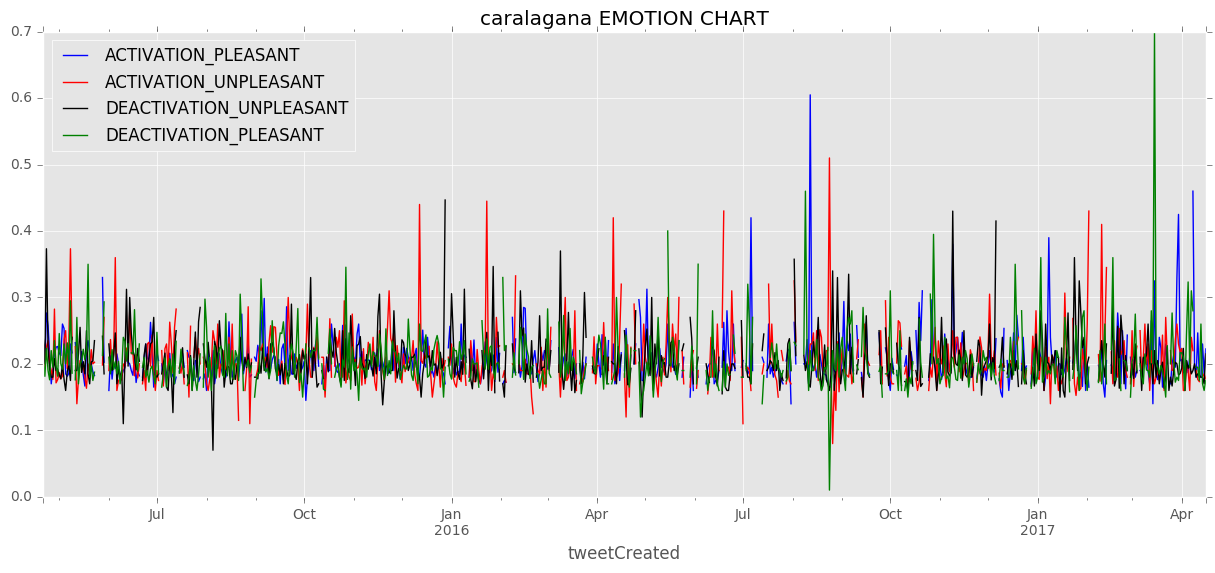

In [85]:
USEREMOTIONS = USER[['ACTIVATION_PLEASANT','ACTIVATION_UNPLEASANT',
                 'DEACTIVATION_UNPLEASANT',
                 'DEACTIVATION_PLEASANT']] #  'positive', 'negative', 'neutral'

USEREMOTIONS = USEREMOTIONS.resample('1D').mean()
#USEREMOTIONS = USEREMOTIONS.fillna(USEREMOTIONS.bfill()) # currently filling with nearest non-null value
USEREMOTIONS.plot(figsize=(15, 6), color = ['blue', 'red', 'black', 'green'], title = USERNAME + ' EMOTION CHART')

found_USER_RECORD = USER_DETAILS.loc[USER_DETAILS['username'] == USERNAME]
print pd.to_datetime(found_USER_RECORD['diagnosisDate']).dt.strftime('%b-%d-%Y')
print found_USER_RECORD['diagstatement']
#plt.show()

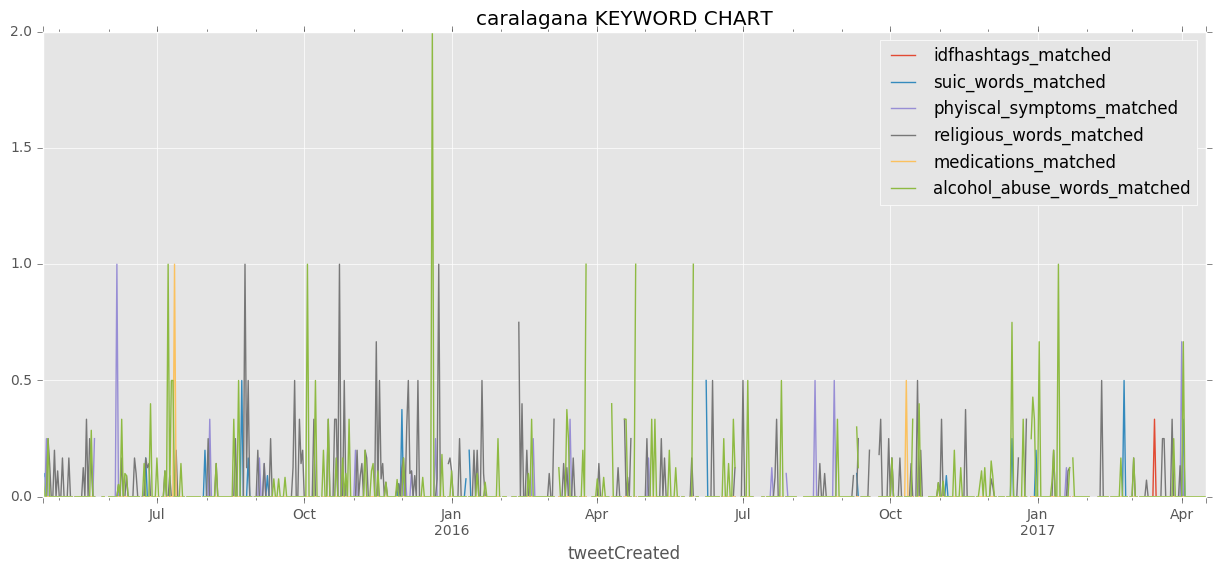

In [86]:
USERKEYWORDS = USER[['idfhashtags_matched', 'suic_words_matched', 'phyiscal_symptoms_matched','religious_words_matched','medications_matched', 'alcohol_abuse_words_matched']]
USERKEYWORDS = USERKEYWORDS.resample('1D').mean()
USERKEYWORDS.plot(figsize=(15, 6), title = USERNAME + ' KEYWORD CHART')
#plt.show()

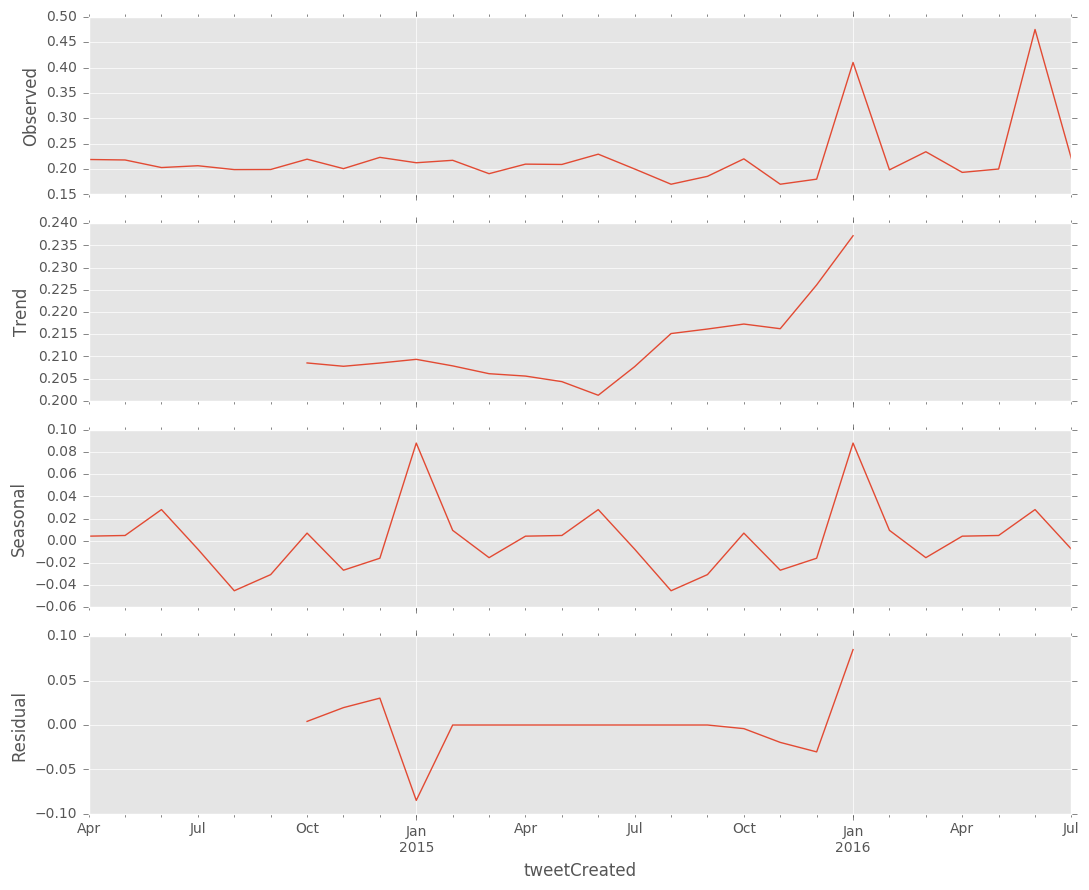

In [160]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.tsa.seasonal_decompose(_gaaaaaaaaaaaby['DEACTIVATION_UNPLEASANT'], model='additive')
fig = decomposition.plot()
plt.show()

In [24]:
# find geometrical center
try:
    keywordLabelled # = pd.read_csv(CSV_sentiment140_output, quotechar='"')
except NameError:
    keywordLabelled = pd.read_csv(CSV_keywords_output)
    
location = USER.tweetLat.mean(), USER.tweetLong.mean()
MAX_RECORDS = 1000

# draw a map using tiles from the Open Street Map project
osm = folium.Map(location, zoom_start=13) #location, zoom_start=13
for info in zip(USER.tweetLat, USER.tweetLong, USER.username):
    folium.Marker(info[:2], popup=info[2]).add_to(osm)
osm.save("normal_users_tweet_locations.html")

In [170]:

#DO AFTER
##################################################################################
# CALCULATE TIME MOOD CHANGES (DIURNAL VARIATION OF MOOD) LABELS: Early morning, mid morning, noon, afternoon, evening, etc.???
# DESCRIPTION:
# For each tweet, tokenize, group all scores for each mood where weighting is over 15%
###################################################################################

## FOCUS:
## label tweet if posted between 12 and 4am
# SAMPLE FORMAT:
# user (Tom)
# day (Jan 1 2017)
# pos(per day- sentiment140) (13)
# neg(per day- sentimen140)  (23)
# angry (#of posts with high angry scores) (avg. score per day)
# happy
# sad 
# amused
# ......
# peaktime_d (peak time of continuous depressed posts of the day) (early morning)
# peaktime_h (peak time of continuous happy posts of the day) (early morning)
# Number tweets posted between 12 and 4am
# hashtags_matched
# ......

#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html
#http://stackoverflow.com/questions/38575443/pandas-resample-to-return-just-one-column-after-an-apply-as-been-made
def calcPeakTimes(args):
    negative = 1
    #for index, row in args.iterrows():
       # if row['polarity'] == 0:
    #negative += 1
    #negative = 0
    #if any(args['polarity'] == 2):
        #args['negative'] = 1
    #if args['polarity'].iloc[0]:
    return negative#{'username' : args.username.values, 'negative' : negative}
    #args.loc[:,'negative'] = negative
    #search_neg = tweets_time_analysis.loc[tweets_time_analysis['polarity'] == 0]
    


tweets_time_analysis = bipolar_tweets_senti140_emotion_keywrds
tweets_time_analysis = tweets_time_analysis.reset_index().set_index('tweetCreated')
tweets_time_analysis.index = pd.to_datetime(tweets_time_analysis.index)

#tweets_time_analysis = tweets_time_analysis.groupby(pd.TimeGrouper(freq='30m'))
#df = tweets_time_analysis.resample("1d").apply(calcPeakTimes)
df = tweets_time_analysis.groupby('username').polarity.resample('1H').apply(lambda x: x == 0) #how='count'

#tweets_time_analysis.polarity.value_counts()
df #[['username', 'polarity', 'negative']]



# TO DO TODAY
# Sample 150 users with less than 50 perc url in tweets, and atleast 15% geotagged tweets
# get most used geo-location
# assign untagged tweets to that location
# label tweets between 12 and 4am with most used geolocation



## 2-5 continous 'low-mood' tweets within a 30 minute period
## 2-5 continous 'happy-mood' tweets within a 30 minute period
## 2-5 continous 'happy to low or low to happy' tweets within a 30 minute period (capture emotional unstableness)

#for row in bipolar_tweets_senti140.itertuples():
    #print row.username

username      tweetCreated       
Demolarsarah  2016-12-24 05:00:00    False
              2016-12-24 06:00:00       []
              2016-12-24 07:00:00       []
              2016-12-24 08:00:00       []
              2016-12-24 09:00:00       []
              2016-12-24 10:00:00       []
              2016-12-24 11:00:00       []
              2016-12-24 12:00:00       []
              2016-12-24 13:00:00       []
              2016-12-24 14:00:00       []
              2016-12-24 15:00:00       []
              2016-12-24 16:00:00       []
              2016-12-24 17:00:00       []
              2016-12-24 18:00:00       []
              2016-12-24 19:00:00       []
              2016-12-24 20:00:00       []
              2016-12-24 21:00:00       []
              2016-12-24 22:00:00       []
              2016-12-24 23:00:00       []
              2016-12-25 00:00:00       []
              2016-12-25 01:00:00       []
              2016-12-25 02:00:00       []
              2016-1

In [ ]:
##################################################################################
# REVERSE GEO-CODE LAT AND LON COORDINATES
# DESCRIPTION
# Use GeoNames web service to reverse geocode lat and lon coords, find points of interest
# REFERENCES:
# https://chrisalbon.com/python/pandas_missing_data.html
# http://stackoverflow.com/questions/26701849/pandas-groupby-and-finding-maximum-in-groups-returning-value-and-count
# http://stackoverflow.com/questions/6159074/given-the-lat-long-coordinates-how-can-we-find-out-the-city-country
# http://www.geonames.org/maps/osm-reverse-geocoder.html
# http://www.geonames.org/export/web-services.html#neighbourhood
###################################################################################
# http://www.shanelynn.ie/batch-geocoding-in-python-with-google-geocoding-api/
# http://geocoder.readthedocs.io/api.html#reverse-geocoding
# https://github.com/gregrobbins/geonames-python/blob/master/geonames.py
# https://developers.google.com/chart/interactive/docs/gallery/geochart
# http://stackoverflow.com/questions/26914900/reverse-geocoding-with-python-geocoder
# http://geocode.xyz/api

bipolar_groupby_user_tweets = bipolar_tweets_with_geo.groupby(['username','tweetLat','tweetLong'])['tweetLong'].agg({'count':'count'})
bipolar_groupby_user_tweets = bipolar_groupby_user_tweets.reset_index()

DOMAIN = 'http://api.geonames.org/'
USERNAME = '' #enter your geonames username here

def fetchJson(method, params):
    uri = DOMAIN + '%s?%s&username=%s' % (method, urllib.urlencode(params), USERNAME)
    resource = urllib2.urlopen(uri).readlines()
    js = json.loads(resource[0])
    return js
def reverseGeocode2(row):
    streets_nearby = []
    lat_coords = row['tweetLat'] #37.451
    long_coords = row['tweetLong'] #-122.18
    

    try:
        
        #resp = urllib2.urlopen(req)
        #req.add_header('Content-Type', 'application/json')
        
        link = "http://api.geonames.org/findNearbyStreetsOSMJSON?lat=%s&lng=%s&username=demo" % (lat_coords, long_coords)
        link = urllib.urlencode(link)
        req = urllib2.Request(link)
        response = urllib2.urlopen(req)
        json_response = json.loads(response.read())

        if json_response and "status" not in json_response and "streetSegment" in json_response:
            for j in json_response['streetSegment']: #for key, value in data.iteritems():
                if "highway" in j:
                    streets_nearby.append(j['highway']) #j['streetSegment'].get('highway', 'None')
                    
            if len(streets_nearby) > 0:
                print collections.Counter(streets_nearby).most_common()[0][0]
                row['nearby'] = collections.Counter(streets_nearby).most_common()[0][0]
            else:
                row['nearby'] = 'None'
                print 'None'
        else:
            # check if has status key and print message
            if 'status' in json_response:
                print json_response['status']['message']
                row['nearby'] = json_response['status']['message']
            else:
                row['nearby'] = 'None'
                print 'None'
        return row
        
    except (urllib2.HTTPError, urllib2.URLError) as err:
        print err
        time.sleep(300)
    except (Exception) as ex: 
        print ex
        
    
#bipolar_groupby_user_tweets_df = splitDataFrameIntoSmaller(bipolar_groupby_user_tweets, 2000)
#bipolar_groupby_user_tweets_df5 = bipolar_groupby_user_tweets_df[4].apply(reverseGeocode2, axis = 1)
#bipolar_groupby_user_tweets_df5.to_csv('bipolar_groupby_user_tweets_df5.csv')
#bipolar_groupby_user_tweets[bipolar_groupby_user_tweets['username']=='badkidvictoria']


geolocator = Nominatim()
location = geolocator.reverse("26.293909, 127.767219")
# can save bounding box using this service
print location.address

g = geocoder.google([26.293909, 127.767219], method='reverse')
print g.address